In [1]:
import numpy as np
import pandas as pd

# Define the number of samples for the synthetic dataset
n_samples = 5000

print(f"Number of samples set to: {n_samples}")

Number of samples set to: 5000


In [2]:
current_biomass = np.random.uniform(50, 500, n_samples)
temperature = np.random.normal(25, 5, n_samples)
humidity = np.random.uniform(30, 90, n_samples)
soil_ph = np.random.normal(6.5, 0.5, n_samples)
salinity = np.random.uniform(0, 10, n_samples)

print("Generated synthetic data for environmental parameters and current biomass.")

Generated synthetic data for environmental parameters and current biomass.


In [3]:
def calculate_biomass_growth(current_biomass, temperature, humidity, soil_ph, salinity):
    # Base growth rate, influenced by current biomass (larger biomass can grow more)
    base_growth = current_biomass * 0.15 # Base 15% growth rate relative to current biomass

    # Environmental factors affecting growth (multipliers)

    # Temperature: Optimal around 25°C, significant drop at extremes
    temp_factor = np.exp(-((temperature - 25)**2) / (2 * (7**2))) # Gaussian distribution around 25 deg C

    # Humidity: Optimal between 50-80%, reduced outside this range
    # Using a piecewise function for simplicity
    humidity_factor = np.where(humidity < 50, 0.7 + (humidity - 30)/20 * 0.3, # Linear increase from 30 to 50
                               np.where(humidity < 80, 1.0, # Optimal 50-80
                                        1.0 - (humidity - 80)/10 * 0.5)) # Linear decrease from 80 to 90
    humidity_factor = np.clip(humidity_factor, 0.5, 1.0) # Ensure factor is between 0.5 and 1.0


    # Soil pH: Optimal around 6.5, significant drop at extremes
    ph_factor = np.exp(-((soil_ph - 6.5)**2) / (2 * (1.0**2))) # Gaussian distribution around pH 6.5

    # Salinity: Higher salinity inhibits growth (inverse relationship)
    salinity_factor = np.clip(1 - (salinity / 15), 0.1, 1.0) # Linear decrease, capped at 0.1

    # Combine factors: Multiply base growth by all environmental factors
    environmental_growth = base_growth * temp_factor * humidity_factor * ph_factor * salinity_factor

    # Add random noise to simulate natural variability
    # Noise magnitude relative to the current biomass and base growth
    noise = np.random.normal(0, current_biomass * 0.02) # Noise std dev is 2% of current biomass

    # Ensure growth is not negative (biomass cannot shrink from incremental growth)
    incremental_growth = np.maximum(0, environmental_growth + noise)

    return incremental_growth

# Calculate the 1-year incremental biomass growth
incremental_biomass_growth = calculate_biomass_growth(
    current_biomass, temperature, humidity, soil_ph, salinity
)

print("Calculated 1-year incremental biomass growth.")

Calculated 1-year incremental biomass growth.


In [4]:
data = {
    'current_biomass': current_biomass,
    'temperature': temperature,
    'humidity': humidity,
    'soil_ph': soil_ph,
    'salinity': salinity,
    'incremental_biomass_growth': incremental_biomass_growth
}
df = pd.DataFrame(data)

print("DataFrame created. Displaying head and info:")
print(df.head())
print("\n")
df.info()

DataFrame created. Displaying head and info:
   current_biomass  temperature   humidity   soil_ph  salinity  \
0       161.142540    25.733881  39.453799  6.038740  9.897513   
1       337.606753    21.840743  64.001176  6.163964  9.013657   
2       431.190341    29.371514  86.816146  6.666653  3.839596   
3       385.894456    20.913443  38.586209  6.408125  9.952309   
4       365.746243    33.245961  49.521782  6.771938  8.492035   

   incremental_biomass_growth  
0                    6.626182  
1                    2.523602  
2                   27.739375  
3                   10.099369  
4                   27.823941  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   current_biomass             5000 non-null   float64
 1   temperature                 5000 non-null   float64
 2   humidity                 

## Prepare Data and Train Model

Split the synthetic dataset into training and testing sets. Train a Random Forest Regressor on the training data.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# 1. Separate features (X) and target (y)
X = df[['current_biomass', 'temperature', 'humidity', 'soil_ph', 'salinity']]
y = df['incremental_biomass_growth']

print("Separated features (X) and target (y).")

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Split data into training and testing sets (80% train, 20% test).")

# 3. and 4. Instantiate a RandomForestRegressor model
model = RandomForestRegressor(random_state=42)

print("Instantiated RandomForestRegressor model.")

# 5. Train the model
model.fit(X_train, y_train)

print("RandomForestRegressor model trained successfully on the training data.")

Separated features (X) and target (y).
Split data into training and testing sets (80% train, 20% test).
Instantiated RandomForestRegressor model.
RandomForestRegressor model trained successfully on the training data.


In [6]:
from sklearn.metrics import mean_squared_error, r2_score

# 1. Use the trained model to make predictions on the test set
y_pred = model.predict(X_test)

print("Model predictions on the test set generated.")

# 2. Calculate the R-squared score
r2 = r2_score(y_test, y_pred)
print(f"R-squared score: {r2:.4f}")

# 3. Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# 4. Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# 5. Define an inference function
def predict_biomass_growth(current_biomass, temperature, humidity, soil_ph, salinity):
    # Create a DataFrame from the input parameters
    input_data = pd.DataFrame([{
        'current_biomass': current_biomass,
        'temperature': temperature,
        'humidity': humidity,
        'soil_ph': soil_ph,
        'salinity': salinity
    }])

    # Predict the incremental biomass growth
    predicted_growth = model.predict(input_data)[0]

    print(f"\nPredicted 1-year incremental biomass growth for the given conditions: {predicted_growth:.2f}")
    return predicted_growth

print("\nInference function 'predict_biomass_growth' defined.")

# 6. Call the function with a sample set of realistic input values
print("\nDemonstrating inference with sample input:")
sample_current_biomass = 250
sample_temperature = 22
sample_humidity = 65
sample_soil_ph = 6.8
sample_salinity = 3

predict_biomass_growth(
    current_biomass=sample_current_biomass,
    temperature=sample_temperature,
    humidity=sample_humidity,
    soil_ph=sample_soil_ph,
    salinity=sample_salinity
)



Model predictions on the test set generated.
R-squared score: 0.7499
Mean Squared Error (MSE): 47.5871
Root Mean Squared Error (RMSE): 6.8983

Inference function 'predict_biomass_growth' defined.

Demonstrating inference with sample input:

Predicted 1-year incremental biomass growth for the given conditions: 26.11


np.float64(26.114072893360213)

# Visualization

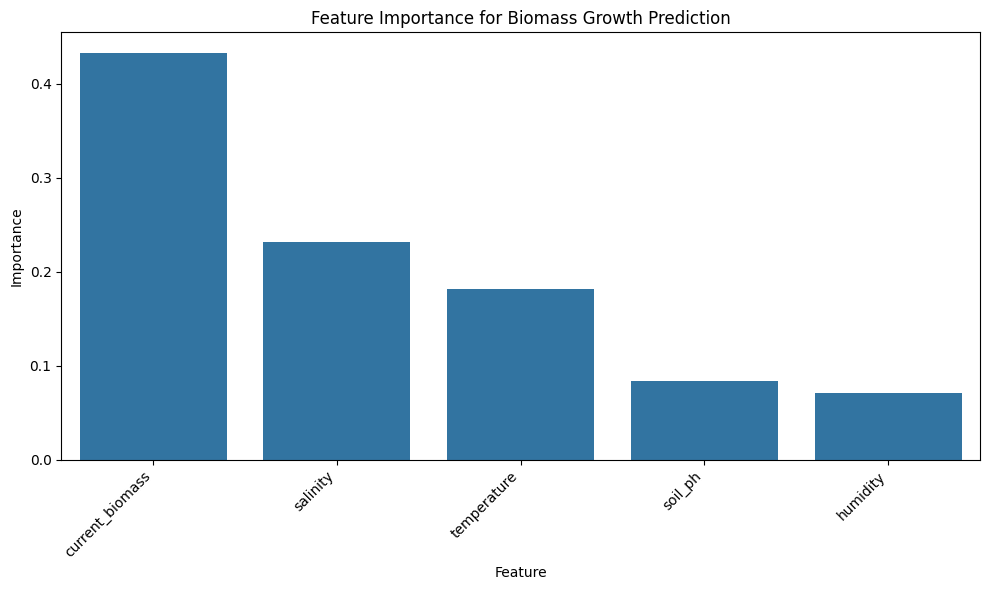

Generated feature importance plot.


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained model
feature_importances = pd.Series(model.feature_importances_, index=X.columns)

# Sort feature importances for better visualization
feature_importances = feature_importances.sort_values(ascending=False)

# Create a bar plot of the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.index, y=feature_importances.values)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance for Biomass Growth Prediction')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Generated feature importance plot.")

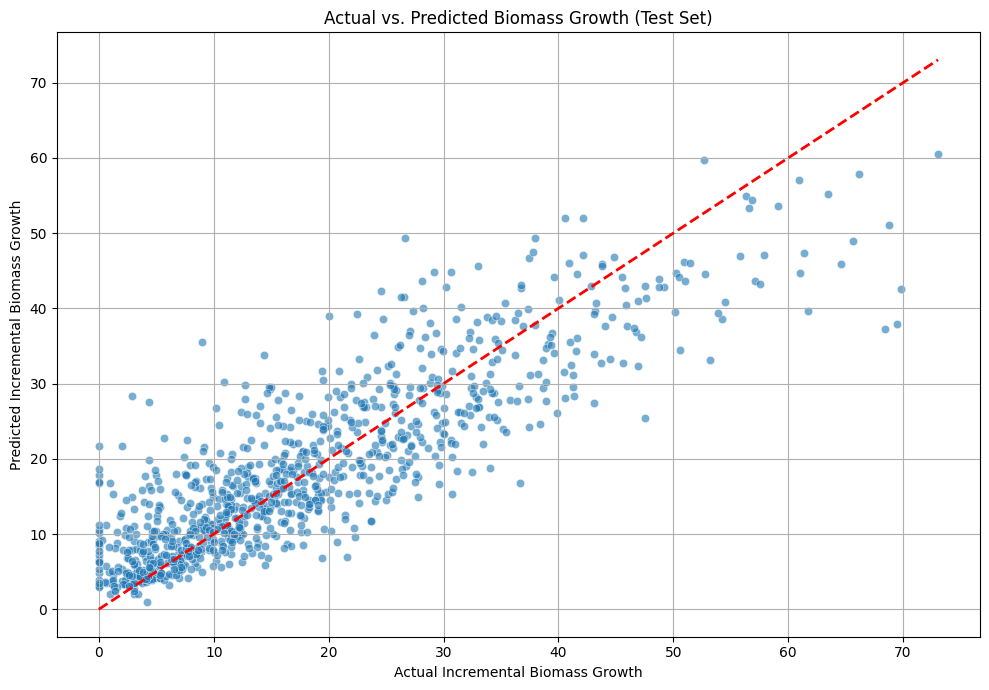

Generated scatter plot comparing actual vs. predicted biomass growth.


In [8]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Diagonal line for perfect prediction
plt.xlabel('Actual Incremental Biomass Growth')
plt.ylabel('Predicted Incremental Biomass Growth')
plt.title('Actual vs. Predicted Biomass Growth (Test Set)')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Generated scatter plot comparing actual vs. predicted biomass growth.")

In [10]:

from google.colab import files
import pickle
model_filename = 'growth_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

files.download(model_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>